In [ ]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
options(repr.matrix.max.rows = 6)

# Predicting Subscriptions 


Gaming-related newspapers want to know what kinds of people would subscribe. This report will determine if experience or age can determine if someone will subscribe. Can time experience at Minecraft or age of person predict if someone subscribes to a newsletter in players.csv?

Lets take a closer look at the players.csv dataset. Below are the first and last couple of rows.

In [3]:
players = read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


There are 7 varibles in this dataset (```experience```, ```subscribe```, ```hashedEmail```, ```played_hours```, ```name```, ```gender```, and ```age```), and there are 196 measurements. Each measurement is a row and repersents a single person. Here is what each varible means: 

- ```experience```: self-described experience at minecraft, one of: Beginner, Amateur, Regular, Pro, Veteran
- ```subscribe```: if someone subscribed to a gaming-related newsletter when given the opportunity
- ```hashedEmail```: the hashed email of the participant
- ```played_hours```: the number of hours played at the time of data collection
- ```name```: name of participant
- ```gender```: gender of participant
- ```Age```: age of participant

This data was collected from a free online minecraft server run by UBC researchers for the goal of eventually getting enough data to create an Artificial Intelligence to play minecraft. The data seems to be good except for a couple of minor inconsistencies in the naming of certain varibles. For instance, ```hashedEmail``` is in camelCase, the first letter of ```Age``` is capitalized, and ```played_hours``` has an underscore. These are minor inconsistencies and should not affect the rest of the data.

# Data Analysis 

Lets start by loading the data again. We will use read_csv to load the dataframe into a variable named "players"

In [68]:
players = read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, lets select the columns we care about, namely ```experience```, ```subscribe```, and ```Age```.

Lets also convert the experience level to a factor in increasing order of proficiency at minecraft. We can do this by first turning experience into a factor using mutate, then specifying the order using factor.

In [69]:
players = select(players, experience, subscribe, Age) |> 
    mutate(experience = as_factor(experience))

players$experience = factor(players$experience, c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))
players

experience,subscribe,played_hours,Age
<fct>,<lgl>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,17
Amateur,FALSE,2.3,17
Pro,TRUE,0.2,NA


Now, lets create two plots. One will be a bar graph plotting number of people of each experience, and colored by subscribe. The second graphs will be a histogram plot for Age, plotting the Age of each person also colored by subscribe.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


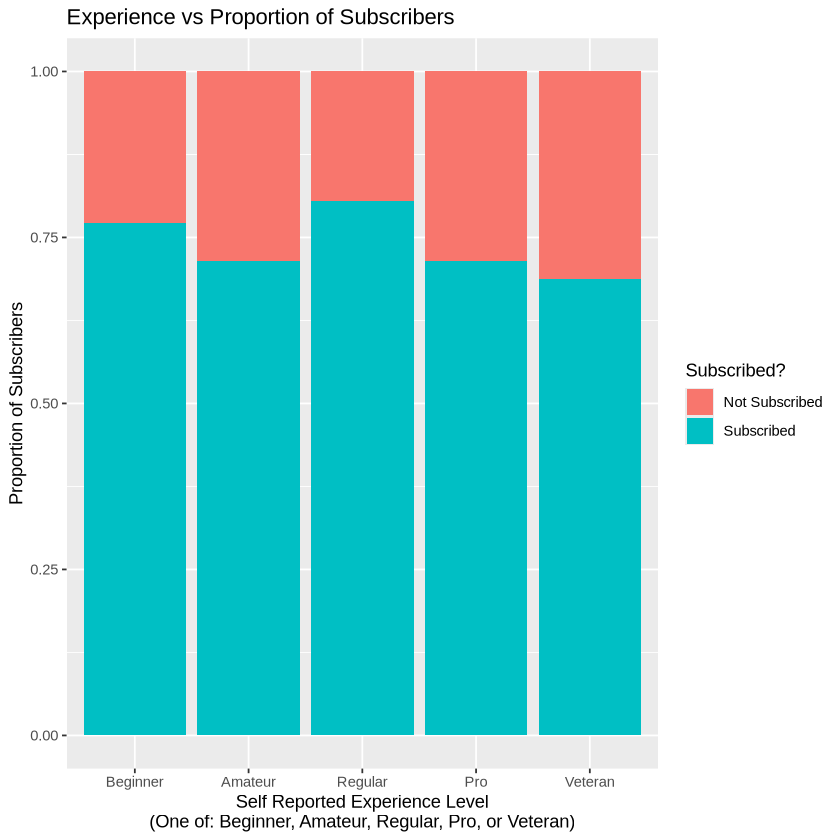

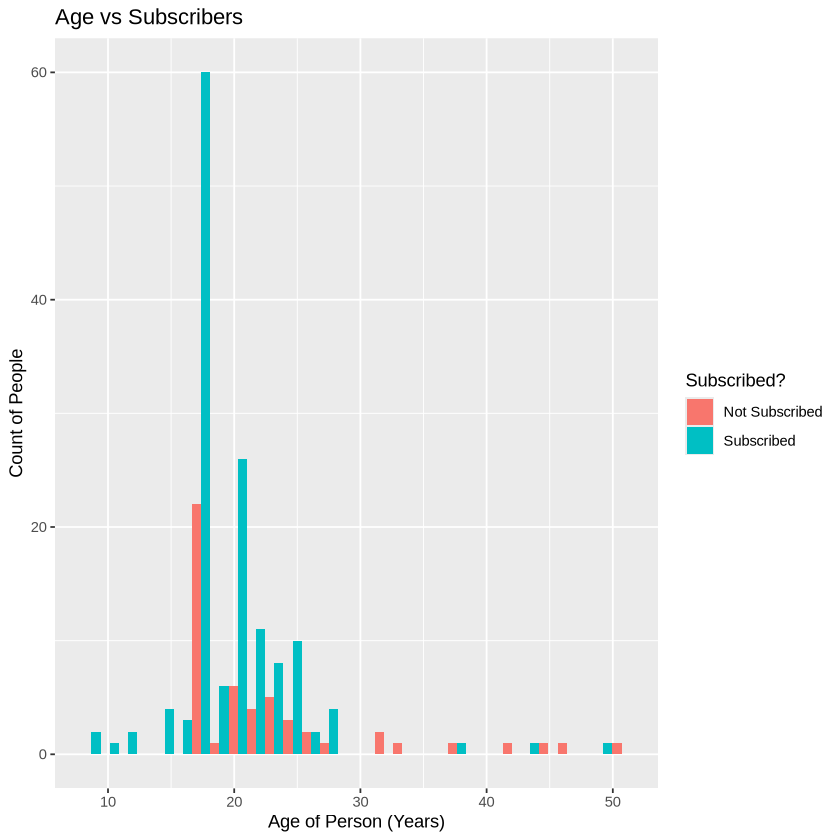

In [76]:
experience_plot = players |> ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Self Reported Experience Level\n(One of: Beginner, Amateur, Regular, Pro, or Veteran)", 
         y = "Proportion of Subscribers", 
         fill = "Subscribed?",
         title = "Experience vs Proportion of Subscribers") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed"))
experience_plot

age_plot = players |> ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram(position = "dodge") + 
    labs(x = "Age of Person (Years)", 
         y = "Count of People", 
         fill = "Subscribed?",
         title = "Age vs Subscribers") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed"))
age_plot